In [1]:
import pandas as pd
import altair as alt
from vega_datasets import data as vega_data
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [2]:
rankings_file_path = "../../data/Daily_Ranking.csv"

In [3]:
df = pd.read_csv(rankings_file_path)

Joining the main rankings dataset with the Country names dataset

In [4]:
df_countries = pd.read_json("countries.json")
df_countries = df_countries.transpose()
df_countries = df_countries.drop(columns=['continent', 'capital', 'languages', 'native', 'phone', 'currency'])
df_countries = df_countries.rename(columns={'name':'Country'})
df_countries.head()
df['Region'] = df['Region'].str.upper()
df = df.merge(df_countries, how='inner', left_on='Region', right_index=True)
print(df.shape)
df.head()

(7338338, 8)


,Position,Track Name,Artist,Streams,URL,Date,Region,Country
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,EC,Ecuador
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,EC,Ecuador
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,EC,Ecuador
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,EC,Ecuador
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,EC,Ecuador


Country name to ID mapping: https://en.wikipedia.org/wiki/ISO_3166-1_numeric

In [5]:
id_mapping_file = "country_id_mapping.csv"
country_id_mapping = pd.read_csv(id_mapping_file)
columns_to_drop = country_id_mapping.columns.tolist()
columns_to_drop.remove('ISO3166-1-Alpha-2')
columns_to_drop.remove('ISO3166-1-numeric')
country_id_mapping = country_id_mapping.drop(columns=columns_to_drop)
country_id_mapping = country_id_mapping.rename(columns={"ISO3166-1-Alpha-2":'Region', "ISO3166-1-numeric":'country_code'})
country_id_mapping = country_id_mapping.dropna()
country_id_mapping["country_code"] = country_id_mapping["country_code"].astype('int')
country_id_mapping.head()

,Region,country_code
0,TW,158
1,AF,4
2,AL,8
3,DZ,12
4,AS,16


In [6]:
df = df.merge(country_id_mapping, how='inner', left_on='Region', right_on="Region")
print(df.shape)
df.head()

(7338338, 9)


,Position,Track Name,Artist,Streams,URL,Date,Region,Country,country_code
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,EC,Ecuador,218
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,EC,Ecuador,218
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,EC,Ecuador,218
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,EC,Ecuador,218
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,EC,Ecuador,218


Now will calculate the ranking change speed for the songs for different countries

In [61]:
df_grouped_position_std = df.drop(columns=['Streams']).groupby(['country_code', 'Track Name'])
df_grouped_position_std = df_grouped_position_std.std()
df_grouped_position_std = df_grouped_position_std.dropna()
df_grouped_position_std = df_grouped_position_std.groupby(['country_code']).mean()
df_grouped_position_std = df_grouped_position_std.rename(columns={'Position':'posstd'})
df_grouped_position_std.index.names = ['id']
df_grouped_position_std = df_grouped_position_std.dropna()
# df_grouped_position_std['posstd'] = df_grouped_position_std['posstd'].astype('int')
df_grouped_position_std['ind'] = df_grouped_position_std.index
df_grouped_position_std.head()

,posstd,ind
id,,
32,29.353942,32
36,34.023985,36
40,35.141576,40
56,35.488476,56
68,23.839282,68


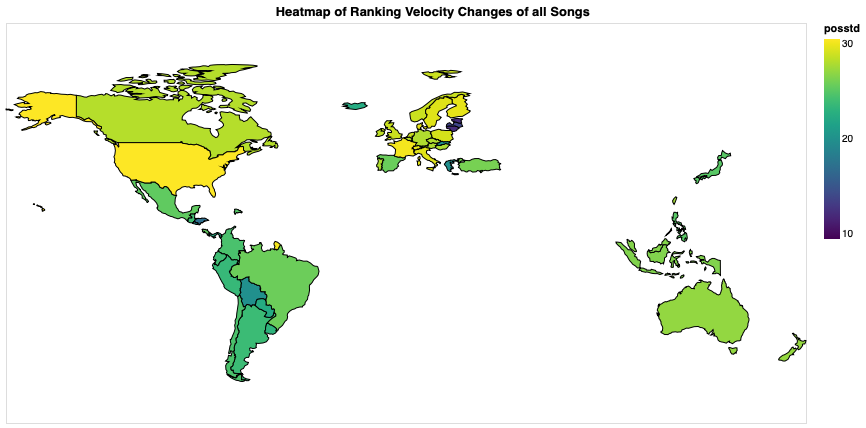

In [98]:
data = df_grouped_position_std
map_source = alt.topo_feature(vega_data.world_110m.url, 'countries')  #no HK in this one :(

base_chart = alt.Chart(map_source, width=800, height=400).mark_geoshape(fill='#666666',stroke='black').transform_lookup(
    lookup='id',
    from_=alt.LookupData(data, 'ind', ['posstd'])
).project('equirectangular').encode(
    color=alt.Color('posstd:Q')
)


(base_chart).properties(title='Heatmap of Ranking Velocity Changes of all Songs')

In [95]:
country_id_mapping = pd.read_csv(id_mapping_file)
columns_to_drop = country_id_mapping.columns.tolist()
columns_to_drop.remove('ISO3166-1-Alpha-3')
columns_to_drop.remove('ISO3166-1-numeric')
country_id_mapping = country_id_mapping.drop(columns=columns_to_drop)
country_id_mapping = country_id_mapping.rename(columns={"ISO3166-1-Alpha-3":'another_code', "ISO3166-1-numeric":'country_code'})
country_id_mapping = country_id_mapping.dropna()
country_id_mapping["country_code"] = country_id_mapping["country_code"].astype('int')
df_grouped_position_std_2 = df_grouped_position_std.merge(country_id_mapping, how='inner', left_index=True, right_on="country_code")
df_grouped_position_std_2.head()

,posstd,ind,another_code,country_code
10,29.353942,32,ARG,32
13,34.023985,36,AUS,36
14,35.141576,40,AUT,40
21,35.488476,56,BEL,56
26,23.839282,68,BOL,68


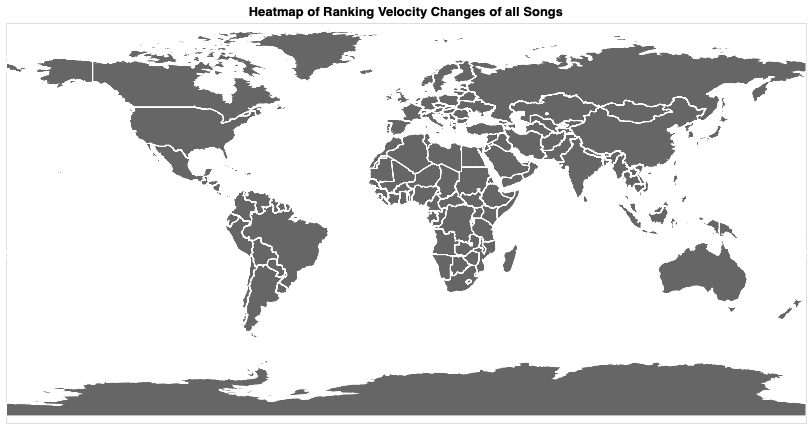

In [97]:
data = df_grouped_position_std_2
other_map = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"

base_chart = alt.Chart(other_map, width=800, height=400).mark_geoshape(fill='#666666',stroke='white'
).transform_lookup(
    lookup='ISO_A3',
    from_=alt.LookupData(data, 'another_code', ['posstd'])
).project('equirectangular').encode(
    color=alt.Color('posstd:Q')
)


(base_chart).properties(title='Heatmap of Ranking Velocity Changes of all Songs')